# Bayesian extrapolation to the drip-line!

In this demo, we will calibrate a simple optical potential to isotopes in the Calcium chain, and build posterior predictive distributions -- that is, uncertainty quantified predictions -- of cross sections for drip-line nuclei!


If you have questions or comments about the contents, feel free to email [beyerk@frib.msu.edu](mailto:beyerk@frib.msu.edu).

In [1]:
#(if you don't have it already)
!pip install nuclear-rose 
!pip install jitr
!pip install corner

import rose
from numba import njit # we need to this to Just-In-Time (JIT) compile our interaction

# other nice things
import numpy as np
import time
import os
from scipy import stats
from pathlib import Path

# import stuff for nice plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import scipy.stats as sps
from tqdm import tqdm
import corner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.1/218.1 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 25.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 53.7 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.3/108.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 47.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.8/140.8 k

## What scientific software will we use?
We will use an open source scattering code called `rose`. It lives here: https://github.com/bandframework/rose. It is meant for constructing emulators for scattering problems, so that one can do Bayesian reaction model calibration quickly. It is also equipped with high-fidelity solvers as well, which we will use. It is set up to be parameteric - the user defines their own model parametric potential and the parmaters that go into it. This is exactly what we will do in today's activity!

## Let's set up our model
We would like to calibrate a simplified version of the East Lansing Model. This simplified version is defined in the standard way:

\begin{align}
    U(r,A) = 
    -&\bigg( V + i W  \bigg) f(r,R,a)  
    - 4 i a W_D \frac{d}{dr} f(r,R,a) \\
    -&\left( \boldsymbol{\ell} \cdot \mathbf{s} \right) 
    \bigg( \frac{\hbar}{m_{\pi} c^2} \bigg)
    \bigg( V_{so} + i W_{so}  \bigg) \frac{1}{r} \frac{d}{dr} f(r,R,a)  
\end{align}


Here $f(r,R,a)$ is the Woods-Saxon form factor:

\begin{equation}
f(r;R,a) = \frac{1}{1 - \exp{\frac{r-R}{a}}}.
\end{equation}

Note that all terms shared the same geometry. The radius of the potential $R$ and the diffuseness are parameterized as without any $A$ dependence aside from the typical volume term. The free parameters $r_A$ and $a$ are in units of fm.

\begin{align}
    R(A) &= r_A A^{1/3} \\
    a &= a_0.
\end{align}

The depths of the volume and surface terms have an isoscalar and isovector component:

\begin{align}
    V(A,Z) &= V \big( 1 \pm  \delta \eta_V \big)  \\
    W(A,Z) &= W \big( 1 \pm  \delta  \eta_W \big)  \\
    W_D(A,Z) &= W_D \big( 1 \pm  \delta  \eta_D  \big),
\end{align}

where $\delta = \frac{N-Z}{N+Z}$ and plus(minus) refers to neutrons(protons). Each of these depths $i$ is parameterized with a ratio between the isovector and isoscalar strengths, $\eta_i$. Note the neglect of any $A$ dependence of the depths aside from the isovector factors. This was chosen due to recent uncertainty quantified calibration of global optical potentials to elastic scattering observables indicating that the correction terms linear in $A$ typically are at least an order of magnitude smaller than corresponding $A$ independent terms, and have uncertainties on the order of their magnitudes. See [Pruitt et al., 2024](https://journals.aps.org/prc/abstract/10.1103/PhysRevC.107.014602).

The depths of the spin-orbit terms will be independent of $A,Z,E$ and have only isoscalar components.

In total, the depths have 8 free parameters; 5 magnitudes $V$, $W$, $W_D$, $V_{so}$ and $W_{so}$, and 3 isovector to isoscalar ratios $\eta_V$, $\eta_W$, $\eta_D$. Including the 2 free geometric parameters, there are 10 free parameters total. Of course we are neglecting energy dependence, and more complex $A$, $Z$ dependencies for the sake of simplicity. 

Our goal for this model is to predict cross sections for rare, neutron-rich isotopes like $^{60}$Ca and $^{70}$Ca. By the way, a (much more advanced than we're doing) optical potential calibration to the Calcium chain has predicted that $^{70}$Ca is indeed bound! See [Charity et al., 2007](https://journals.aps.org/prc/abstract/10.1103/PhysRevC.107.014602). To be able to make predictions for these rare isotopes, the isovector dependence will be really important, because we will be extrapolating away from stability.

In [2]:
from rose.utility import woods_saxon_safe, woods_saxon_prime_safe, thomas_safe
from rose.constants import MASS_PION

# for labeling plots
elm_param_labels = [
    r"$V$ [MeV]",
    r"$W$ [MeV]",
    r"$W_D$ [MeV]",
    r"$V_{so}$ [MeV]",
    r"$W_{so}$ [MeV]",
    r"$\eta_V$",
    r"$\eta_W$",
    r"$\eta_D$",
    r"$r_A$ [fm]",
    r"$a_0$ [fm]",
]


@njit
def el_model_simple(r, params):
    r"""evaluate the EL model (without spin-orbit) as a function of radial distance r"""
    V, W, Wd, Vso, Wso, R, a = params
    return -(V + 1j * W) * woods_saxon_safe(r, R, a) + (4j * a * Wd) * woods_saxon_prime_safe(
        r, R, a
    )


@njit
def el_model_simple_so(r, params, lds):
    r"""ELM spin-orbit terms
    lds: l • s = 1/2 * (j(j+1) - l(l+1) - s(s+1))
    """
    V, W, Wd, Vso, Wso, R, a = params
    return lds * (Vso + 1j * Wso) / MASS_PION**2 * thomas_safe(r, R, a)


@njit
def el_model_params(A, Z, *sub_params):
    r"""Calculate the parameters in the EL model for a given target isotope
    and energy with a neutron as the incident projectile"""
    asym = (A - 2 * Z) / (A)
    V, W, Wd, Vso, Wso, etaV, etaW, etaD, rA, a0 = sub_params
    return (
        V * (1 + asym * etaV),
        W * (1 + asym * etaW),
        Wd * (1 + asym * etaD),
        Vso,
        Wso,
        rA * A ** (1.0 / 3.0),
        a0,
    )


elm_num_sub_params = 10  # the sub params map from A,Z to the params
elm_num_params = 7

### Let's find some data to calibrate to
Let's grab some data from [EXFOR](https://www-nds.iaea.org/exfor/). We will calibrate to $d\sigma_{el}/d\Omega$ for $(n,n)$ along the Calcium isotopic chain at energies around 10 MeV.


#### $^{40}$Ca
 - [Mueller et al., 2011 $(n,n)$ at $11.9 \pm 0.207$ MeV](https://www-nds.iaea.org/exfor/servlet/X4sGetSubent?reqx=16243&subID=14303002&plus=1)
 - [Mueller et al., 2011 $(n,n)$ at $16.9 \pm 0.141$ MeV](https://www-nds.iaea.org/exfor/servlet/X4sGetSubent?reqx=16280&subID=14303003&plus=1)

 
#### $^{48}$Ca
- [Mueller et al., 2011 $(n,n)$ at $11.9 \pm 0.207$ MeV](https://www-nds.iaea.org/exfor/servlet/X4sGetSubent?reqx=15364&subID=14303004&plus=1)
- [Mueller et al., 2011 $(n,n)$ at $16.8 \pm 0.141$ MeV](https://www-nds.iaea.org/exfor/servlet/X4sGetSubent?reqx=16286&subID=14303005&plus=1)
- [Hicks et al. 1988 $(n,n)$ at $7.97 \pm 0.22$ MeV](https://www-nds.iaea.org/exfor/servlet/X4sGetSubent?reqx=15369&subID=13507002&plus=1)

I'll just copy that data below for us:

In [3]:
import pandas as pd

data = {}
data[40] = {}
data[48] = {}
data[40]["Mueller_119"] = np.array(
    [
        [46.0, 38.28, 4.6],
        [51.1, 43.98, 4.0],
        [56.2, 40.65, 4.6],
        [61.2, 47.98, 11.9],
        [66.3, 32.38, 4.3],
        [86.4, 13.91, 5.7],
        [91.4, 19.22, 4.6],
        [101.4, 27.03, 3.6],
        [111.4, 21.02, 4.0],
        [116.3, 17.05, 5.0],
        [131.1, 12.72, 7.3],
        [140.9, 10.80, 5.0],
    ]
)
data[40]["Mueller_169"] = np.array(
    [
        [40.9, 44.38, 7.82],
        [61.2, 53.05, 6.48],
        [101.4, 19.35, 4.49],
        [111.4, 11.39, 4.10],
        [116.3, 7.95, 7.66],
        [121.2, 5.24, 8.42],
        [131.1, 3.86, 6.78],
        [136.0, 4.18, 8.83],
    ]
)

data[48]["Mueller_119"] = np.array(
    [
        [35.68, 125.76, 4.0],
        [40.77, 66.18, 4.4],
        [45.84, 42.44, 5.5],
        [50.91, 40.29, 3.8],
        [55.98, 38.31, 4.7],
        [61.03, 44.21, 4.4],
        [66.08, 42.53, 4.2],
        [71.12, 39.12, 3.6],
        [76.15, 28.83, 4.3],
        [81.18, 26.77, 4.5],
        [86.19, 28.42, 4.0],
        [91.19, 28.48, 3.8],
        [96.19, 31.58, 3.6],
        [101.18, 35.33, 3.2],
        [106.15, 36.22, 3.4],
        [111.12, 35.75, 3.5],
        [116.08, 34.58, 4.0],
        [121.03, 26.54, 3.2],
        [125.98, 21.79, 5.3],
        [130.91, 15.81, 4.7],
        [135.84, 13.50, 7.0],
        [140.77, 16.36, 3.3],
        [142.74, 19.39, 3.7],
    ]
)

data[48]["Mueller_168"] = np.array(
    [
        [35.7, 35.20, 13.9],
        [40.8, 74.50, 4.6],
        [45.8, 91.89, 4.0],
        [50.9, 97.90, 3.5],
        [61.0, 57.67, 4.1],
        [66.1, 38.19, 5.8],
        [71.1, 19.95, 5.5],
        [76.2, 28.45, 4.2],
        [81.2, 29.66, 4.3],
        [86.2, 29.46, 4.1],
        [91.2, 28.41, 4.0],
        [96.2, 24.35, 4.3],
        [101.2, 18.54, 3.3],
        [106.2, 17.94, 4.6],
        [111.1, 15.41, 3.7],
        [116.1, 13.90, 4.5],
        [121.0, 10.50, 3.4],
        [126.0, 11.05, 5.4],
        [130.9, 9.07, 4.0],
        [135.8, 8.78, 5.2],
        [140.8, 10.71, 5.7],
        [143.7, 11.80, 4.8],
    ]
)

data[48]["Hicks_797"] = np.array(
    [
        [25.5, 1243.0, 2.3],
        [30.6, 887.7, 2.2],
        [40.8, 355.5, 2.9],
        [50.9, 111.5, 3.9],
        [61.0, 26.5, 7.9],
        [71.1, 10.4, 6.7],
        [76.2, 8.3, 6.7],
        [81.2, 7.3, 7.5],
        [91.2, 17.2, 4.2],
        [101.2, 37.6, 2.8],
        [111.1, 48.7, 2.7],
        [121.0, 38.9, 2.4],
        [130.9, 32.4, 2.8],
        [140.8, 36.4, 3.0],
        [150.6, 61.9, 2.2],
    ]
)

energies = {}
energies[48]  ={
    "Hicks_797": 7.97,
    "Mueller_168": 16.8,
    "Mueller_119": 11.9,
}
energies[40]  ={
    "Mueller_169": 16.9,
    "Mueller_119": 11.9,
}

Ca40 = (40, 20)
Ca48 = (48, 20)
isotopes = {48: Ca48, 40: Ca40}

# for plotting differential xs
angles = np.linspace(0.1, np.pi, 100)

In [4]:
# rescale from percent to absolute error
for A in data:
    for experiment in data[A]:
        data[A][experiment][:, 2] = data[A][experiment][:, 2] * data[A][experiment][:, 1] / 100

In [5]:
data[A][experiment][:, 2]

array([28.589 , 19.5294, 10.3095,  4.3485,  2.0935,  0.6968,  0.5561,
        0.5475,  0.7224,  1.0528,  1.3149,  0.9336,  0.9072,  1.092 ,
        1.3618])

### Let's compare our data to an out-of-the-box optical model potential

`rose` very handily has some global optical potentials already built for us, so we can go ahead and see how they do on the cross sections we just picked out before we try to calibrate our own. We will use the the KDUQ potential from [Pruitt et al., 2024](https://journals.aps.org/prc/abstract/10.1103/PhysRevC.107.014602) potential. The supplemental material in that link contains a set of samples from the posterior of the KDUQ parameter distribution. Let's load them up:

In [6]:
# we have 416 samples from the KDUQ posterior, but let's only look at 50 
N_samples = 100
param_files = [ Path(f"./KDUQFederal/{i}/parameters.json") for i in range(0,N_samples-1)]

# load each one
kduq_omps = [
    rose.koning_delaroche.KDGlobal(rose.Projectile.neutron, Path(param_file))
    for param_file in param_files
]

We will create an instance of a `rose.InteractionSpace` and a `rose.ScatteringAmplitudeEmulator` for each of these potentials, and we will use the high-fidelity solver to calculate the cross sections predicted by each model.

We will use a high-fidelity solver from the [jitr package](https://github.com/beykyle/jitr) which uses the R-Matrix method on a Lagrange-Legendre mesh.

In [7]:
import jitr
core_solver = jitr.RMatrixSolver(100)

In [8]:
%%time
kduq_xs = {}
kduq_pred_post = {}

# for each experiment, and for each parameter sample, 
# use the rose high-fidelity solver to calculate the 
# KDUQ prediction 
for A in data.keys():
    isotope = isotopes[A]
    kduq_xs[A] = {}
    kduq_pred_post[A] = {}

    for experiment in data[A].keys():
        
        # what energy was this experiment performed at?
        E_lab = energies[A][experiment]
        
        # get kinematics and parameters for this experiment
        mu, E_com, k, eta = rose.utility.kinematics(isotope, (1, 0), E_lab=E_lab)

        # admittedly, rose is great for emulation but is pretty clunky if you're
        # just using the high-fidelity solver across different energies and isotopes
        # maybe you can fix this: https://github.com/bandframework/rose/issues/68
        # welcome to open source software!
        kduq = rose.InteractionSpace(
            coordinate_space_potential=rose.koning_delaroche.KD_simple,
            n_theta=rose.koning_delaroche.NUM_PARAMS,
            is_complex=True,
            spin_orbit_term=rose.koning_delaroche.KD_simple_so,
            energy=E_com,
            mu=mu,
            k=k,
            l_max=30,
        )
        rmatrix_solver = rose.LagrangeRmatrix(
            kduq.interactions[0][0],
            np.pi * 10,
            core_solver,
        )
        kduq_solver = rose.ScatteringAmplitudeEmulator.HIFI_solver(
            base_solver=rmatrix_solver,
            interaction_space=kduq,
            angles=angles,
        )
        
        # get a differential xs for each parameter sample
        kduq_xs[A][experiment] = np.zeros((len(angles), N_samples))
        for i in tqdm(range(0,N_samples-1)):
            _, params = kduq_omps[i].get_params(*isotope, mu, E_lab, k)
            kduq_xs[A][experiment][:,i] = kduq_solver.exact_xs(params).dsdo
        
        # get a credible interval describing the KDUQ predictive posterior
        # for this experiment
        kduq_pred_post[A][experiment] = (
            np.percentile(kduq_xs[A][experiment], 5, axis=1),
            np.percentile(kduq_xs[A][experiment], 95, axis=1)
        )

  0%|          | 0/99 [00:00<?, ?it/s]/usr/local/python/3.10.13/lib/python3.10/site-packages/jitr/rmatrix.py:46: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(complex128, 1, 'C', False, aligned=True), Array(complex128, 2, 'A', False, aligned=True))
  R, Ainv = rmatrix_with_inverse(A, b, nchannels, nbasis, a)
100%|██████████| 99/99 [00:01<00:00, 63.16it/s]

CPU times: user 1min 23s, sys: 239 ms, total: 1min 23s
Wall time: 1min 16s


Now that we have our model predictions, lets plot them compared to the experimental data. We will offset each energy for visibility.

/tmp/ipykernel_22887/3345717025.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


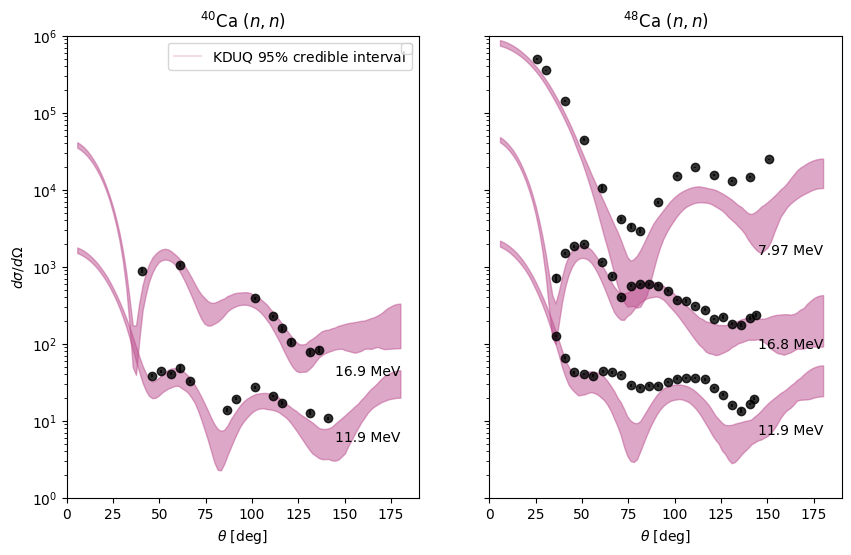

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
for A, ax in zip(data.keys(), [ax1, ax2]):
    offset = 1
    ax.set_title(r"$^{%d}$Ca $(n,n)$" % A)
    ax.set_xlabel(r"$\theta$ [deg]")
    ax.set_xlim([0, 190])
    for experiment in data[A].keys():
        
        # plot experiment
        x, y, dy = (
            data[A][experiment][:, 0],
            data[A][experiment][:, 1],
            data[A][experiment][:, 2],
        )
        ax.errorbar(
            x,
            offset * y,
            offset * dy,
            marker="o",
            alpha=0.8,
            linestyle="none",
            color='k'
        )
        
        # plot model
        ax.fill_between(
            angles * 180 / np.pi,
            offset * kduq_pred_post[A][experiment][0],
            offset * kduq_pred_post[A][experiment][1],
            color="#bc5090",
            alpha=0.5,
        )
        
        # add a label
        energy = energies[A][experiment]
        label_loc = (145, offset * np.min(y)/2)
        ax.text(*label_loc, f"{energy} MeV")
        
        offset *= 20

leg_models = [
    Line2D([0], [0], color="#bc5090", label=r"KDUQ $95\%$ credible interval", alpha=0.2),
]
leg1 = ax1.legend(handles=leg_models, loc="upper right")
ax1.add_artist(leg1)


plt.ylim([1, 1e6])
plt.yscale("log")
ax1.set_ylabel(r"$d\sigma/d\Omega$")
ax1.legend()

Turns out KDUQ isn't bad, but some of the data points are definitely outside of the 95% credible interval. Addtionally, for some of those points, there is negligible experimental data. In particular, the first big diffraction peak in the $^{48}$Ca @ 11.9 MeV data set and the large angles of the $^{48}$Ca @ 11.9 and 7.97 MeV sets seem to have statistically significant disagreement between model and experiment. What could be going on here?

Let's see how we do with our simple EL model. But first, running the high-fidelity solver in rose 50 times for each of the 5 experiments took a few minutes. Doing a full calibration may require hundreds of thousands of parameter samples. We need to build an emulator! But first, let's specify a prior for our EL model.

## Specifying the Prior

We need a prior distribution of the 9 parameters that go into our EL model. For the sake of simplicity, we will just guestimate this prior by looking at KDUQ (see Table V. in [Pruitt et al., 2024](https://journals.aps.org/prc/abstract/10.1103/PhysRevC.107.014602)). We will assume our prior can be described by a multivariate normal.

In [10]:
# just guestimate based on KDUQ
# notice the relative uncertainties are quite large in some cases!
mean = np.array([50, 5, 16, 5.99, -3.79, 13.4 / 60.0, 0, 11.1 / 20, 1.27, 0.689])
stdev = np.array([5.0, 10.0, 10, 1.8, 4, 8.0 / 60, 2.0 / 20, 10 / 20, 0.07, 0.05])

# we will assume uncorrelated priors
covariance = np.zeros((10, 10))
covariance += np.diag(stdev**2)

In [37]:
prior_distribution = stats.multivariate_normal(mean, covariance)
prior = prior_distribution.rvs(size=10000)

We have our samples, let's visualize them:

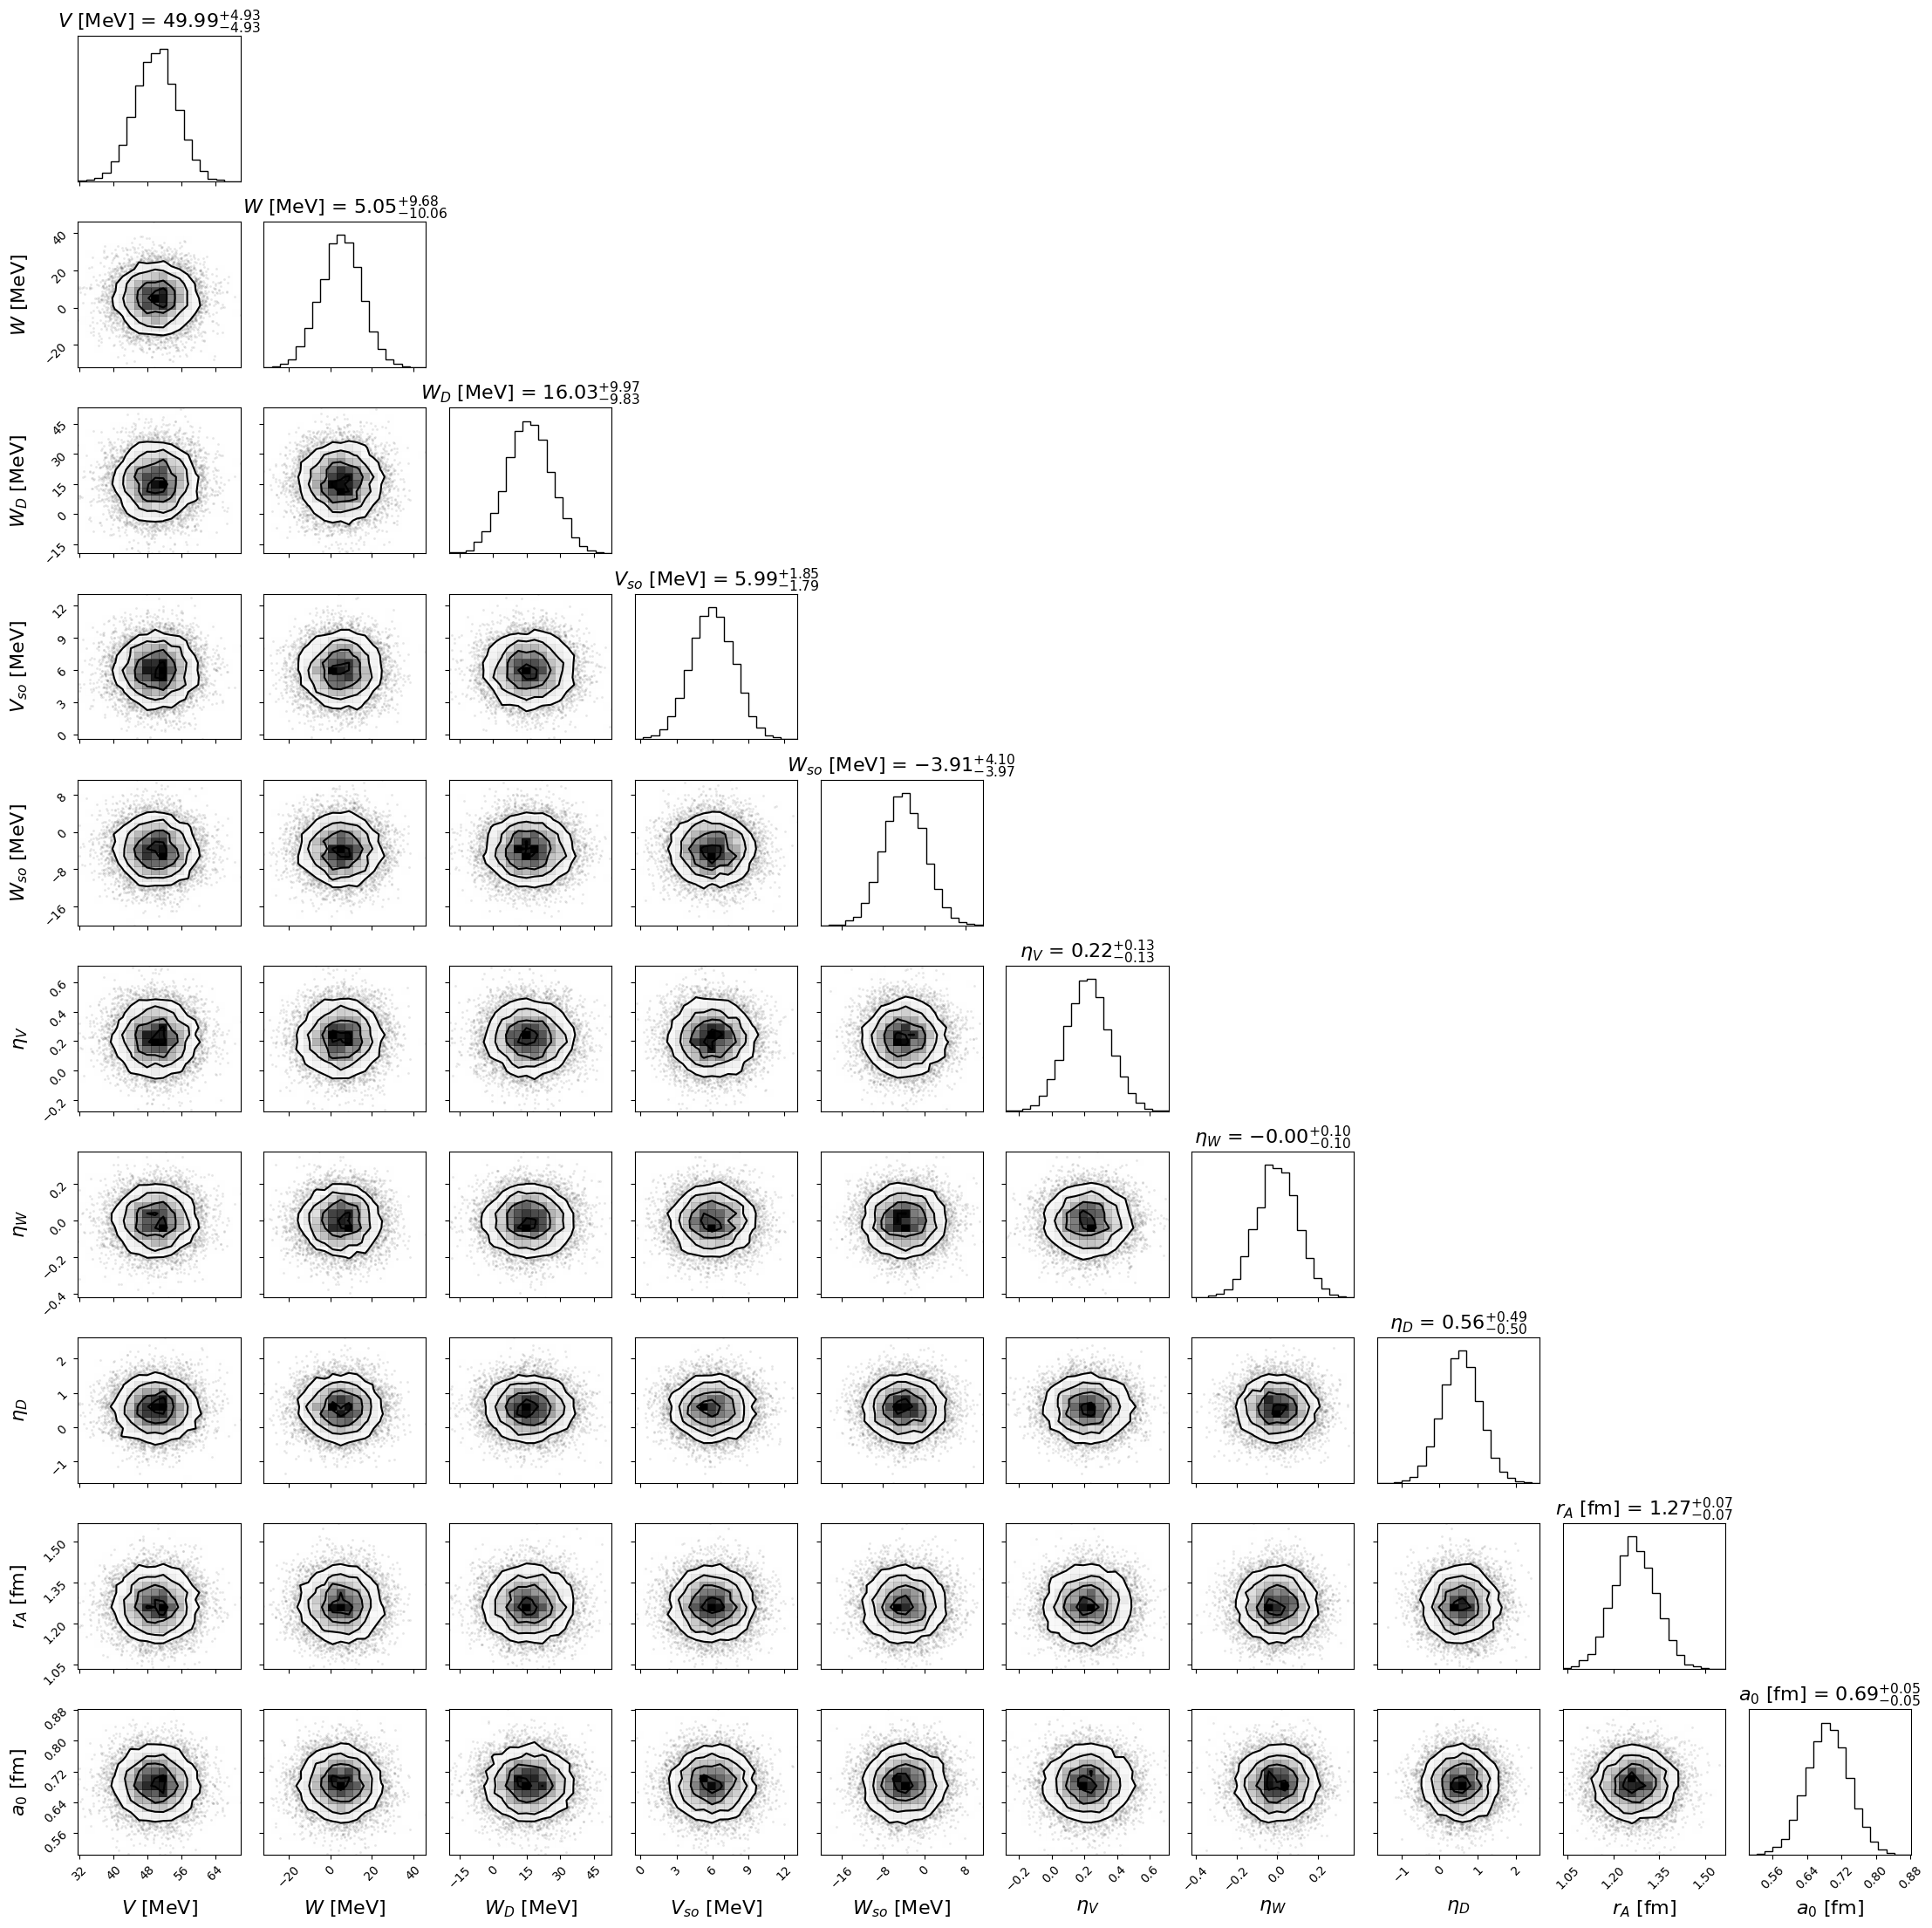

In [38]:
fig = corner.corner(
    prior,
    labels=list(elm_param_labels),
    show_titles=True,
    title_kwargs={"fontsize": 16},
    label_kwargs={"fontsize": 16},
)
fig.tight_layout()

Nice! We can use these samples to initiate our MCMC walkers in our Bayesian calibration. But first, let's build an emulator.

## Training a rose emulator
To make this calibration doable on your laptop, we will use a reduced basis method emulator called [`rose`](github.com/bandframework/rose). For the theory behind it, see:
- https://dr.ascsn.net/landing.html
- https://journals.aps.org/prc/abstract/10.1103/PhysRevC.109.044612

The software is open source and lives here: https://github.com/bandframework/rose

The easiest way to go about this will be to emulate across the parameters in `el_model_simple`, rather than subparameters that we actually want to do a statistical calibration for. Let's convert our prior of sub-parameters into the parameters we want to emulate across, so we can determine the region of interest on which to train our emulator.

In [13]:
s_max = np.pi * 10
mesh_size = 1000
s_mesh = np.linspace(0.02, s_max, mesh_size)

# what fraction of variance in the training set should we describe? 
# this determines how many basis elements to use in the reduced basis
max_fraction_unexplained_variance = 1.0e-7

In [14]:
%%time
emulators = {}
roi_bounds = {}

for A in data.keys():
    isotope = isotopes[A]
    emulators[A] = {}
    roi_bounds[A] = {}
    for experiment in data[A].keys():
        x, y, dy = (
            data[A][experiment][:, 0],
            data[A][experiment][:, 1],
            data[A][experiment][:, 2],
        )
        # what energy was this experiment performed at?
        E_lab = energies[A][experiment]

        # get kinematics and parameters for this experiment
        mu, E_com, k, _ = rose.utility.kinematics(isotope, (1, 0), E_lab=E_lab)

        # get prior distribution of main params for given isotope
        prior_roi_samples = np.array(
            [el_model_params(*isotope, *sample) for sample in prior]
        )

        # find bounds of this ROI (region of interest)
        roi_bounds[A][experiment] = np.array(
            [
                np.min(prior_roi_samples, axis=0),
                np.max(prior_roi_samples, axis=0),
            ]
        ).T
            
        # sample some training parameters using Latin Hypercube to get all corners 
        # of our ROI
        train = rose.utility.latin_hypercube_sample(100, bounds=roi_bounds[A][experiment], seed=13)

        # set up the rose interaction space for emulation
        elm_interaction = rose.InteractionEIMSpace(
            coordinate_space_potential=el_model_simple,
            spin_orbit_term=el_model_simple_so,
            n_theta=elm_num_params,
            is_complex=True,
            expl_var_ratio_cutoff=max_fraction_unexplained_variance,
            rho_mesh=s_mesh,
            training_info=roi_bounds[A][experiment],
            l_max=15,
            mu=mu,
            energy=E_com,
            k=k,
        )
        
        # set up high-fidelity solver for training and testing the emulator
        rmatrix_solver = rose.LagrangeRmatrix(
            elm_interaction.interactions[0][0],
            s_0=s_max,
            solver=jitr.RMatrixSolver(50)
        )

        # train the emulator
        emulators[A][experiment] = rose.ScatteringAmplitudeEmulator.from_train(
            interaction_space=elm_interaction,
            base_solver=rmatrix_solver,
            alpha_train=train,
            s_mesh=s_mesh,
            expl_var_ratio_cutoff=max_fraction_unexplained_variance,
            angles=x * np.pi/180,
        )

100%|██████████| 16/16 [00:40<00:00,  2.56s/it]


CPU times: user 9min 2s, sys: 4.67 s, total: 9min 7s
Wall time: 6min 32s


## Testing the emulator
Nice! We have a trained emulator. But we should make sure it actually works. Fortunately, `rose` is set up with a bit of a cheat code for this: because it is a projective method, it will work so long as the basis it projects onto sufficiently describes the high-fidelity description. A good metric for this is how many basis elements we kept - if it's a reasonably small number, than we have done a good job in reducing the dimensions!

In [15]:
# let's check one of the emulators
swave_basis = emulators[48]["Mueller_168"].rbes[0][0].basis
sv_sqr_kept =  np.sum(swave_basis.singular_values[:swave_basis.n_basis] ** 2)
sv_sqr_all = np.sum( swave_basis.singular_values ** 2 )
explained_variance = sv_sqr_kept / sv_sqr_all
print(
    f"The S-wave channel required {swave_basis.n_basis} "
    f"basis elements to describe all but {(1.0 - explained_variance)*100:1.6e}% "
    "of the variance in the training set."
)

The S-wave channel required 10 basis elements to describe all but 7.418576e-06% of the variance in the training set.


A more thorough way to test is to compare high-fidelity and emulated observables for a set of test samples not on the training set:

In [16]:
test = rose.utility.latin_hypercube_sample(
    30, bounds=roi_bounds[48]["Mueller_168"], seed=191
)

In [17]:
%%time
# run high-fidelity solver
HIFI_xs = []
for sample in tqdm(test):
    HIFI_xs.append(emulators[48]["Mueller_168"].exact_xs(sample, angles=angles))

100%|██████████| 30/30 [00:00<00:00, 172.01it/s]

CPU times: user 168 ms, sys: 4 ms, total: 172 ms
Wall time: 178 ms


In [18]:
%%time
# run emulator
emu_xs = []
for sample in tqdm(test):
    emu_xs.append(emulators[48]["Mueller_168"].emulate_xs(sample, angles=angles))

100%|██████████| 30/30 [00:00<00:00, 118.69it/s]

CPU times: user 105 ms, sys: 15.7 ms, total: 121 ms
Wall time: 255 ms


Text(0, 0.5, '$d \\sigma / d \\Omega$ ')

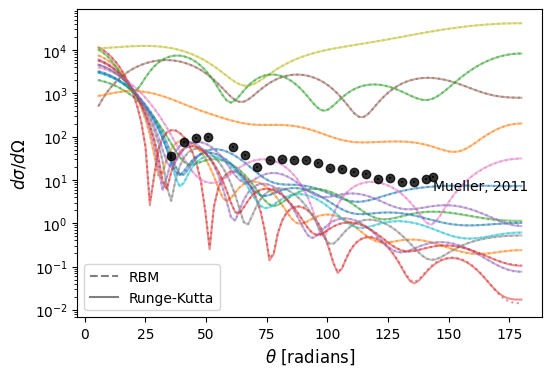

In [19]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(6, 4))
fig.patch.set_facecolor("white")

for i, sample in enumerate(test[::2]):
    x = angles * 180 / np.pi

    # HIFI
    y_exact = HIFI_xs[i].dsdo

    # emulated
    y_emu = emu_xs[i].dsdo

    p = ax.plot(x, y_emu, ":", alpha=0.5)
    ax.plot(x, y_exact, color=p[0].get_color(), alpha=0.5)

# plot experiment
x, y, dy = (
    data[48]["Mueller_168"][:, 0],
    data[48]["Mueller_168"][:, 1],
    data[48]["Mueller_168"][:, 2],
)
ax.errorbar(
    x, y, dy, marker="o", alpha=0.8, linestyle="none", color="k"
)

ax.text(x[-1], y[-1]*0.5, "Mueller, 2011")
legend_styles = [
    Line2D([0], [0], color="k", linestyle="--", alpha=0.5),
    Line2D([0], [0], color="k", alpha=0.5),
]
ax.legend(legend_styles, ["RBM", "Runge-Kutta"])
ax.set_yscale("log")
plt.xlabel(r"$\theta$ [radians]", fontsize=12)
plt.ylabel(r"$d \sigma / d \Omega$ ", fontsize=12)

In real life, we should really do some more thorough convergence testing to make sure our emulator is robust, and characterize its relative error!

## Building a statistical model

In [20]:
emulator_err = 0.05
model_err = 0.05
def log_likelihood(subparams):
    log_likelihood = 0
    for A in data.keys():
        isotope = isotopes[A]
        params = el_model_params(*isotope, *subparams)
        for experiment in data[A].keys():
            x, y, dy = (
                data[A][experiment][:, 0],
                data[A][experiment][:, 1],
                data[A][experiment][:, 2],
            )
            y_model = emulators[A][experiment].emulate_xs(params).dsdo
            log_likelihood -= 0.5 *np.sum(
                (y - y_model)**2 / (dy + emulator_err * y_model + model_err*y_model)**2 
            )
    return log_likelihood 

In [39]:
def log_prior(subparams):
    return prior_distribution.logpdf(subparams)

In [40]:
def log_posterior(subparams):
    return log_likelihood(subparams) + log_prior(subparams)

## Performing the calibration

In [49]:
# I'm walkin here
n_walkers = 1#2
n_accepted = np.zeros(n_walkers)
n_iter = 20000
n_burn = 4000

# place to put samples
mcmc_samples = np.zeros((n_walkers, n_iter - n_burn, elm_num_sub_params))

# proposal distribution
# step_sizes0 = 0.1 * np.sqrt(np.diag(covariance))
step_sizes0 = 0.1 * np.array([10, 8.0, 10.0, 1.8, 4.0, 0.18333333, 0.2, 0.9, 0.1, 0.1])
step_distribution_mean = np.zeros(elm_num_sub_params)
step_distribution_cov = np.zeros((elm_num_sub_params, elm_num_sub_params))
step_distribution_cov += np.diag(step_sizes0) ** 2

In [50]:
%%time
for i in range(n_walkers):
    # start walker by grabbing a sample from the prior
    sample = prior[i]

    # walk until you get tired
    for j in tqdm(range(n_iter)):
        next_sample = sample + np.random.multivariate_normal(
            step_distribution_mean, step_distribution_cov
        )
        acceptance_prob = np.exp(-log_posterior(next_sample) + log_posterior(sample))
        
        if j >= n_burn:
            if np.random.rand() > acceptance_prob:
                sample = next_sample
                n_accepted[i] += 1
        
            mcmc_samples[i,j-n_burn,:] = sample

100%|██████████| 20000/20000 [06:46<00:00, 49.23it/s]

CPU times: user 6min 41s, sys: 12.2 s, total: 6min 53s
Wall time: 6min 46s


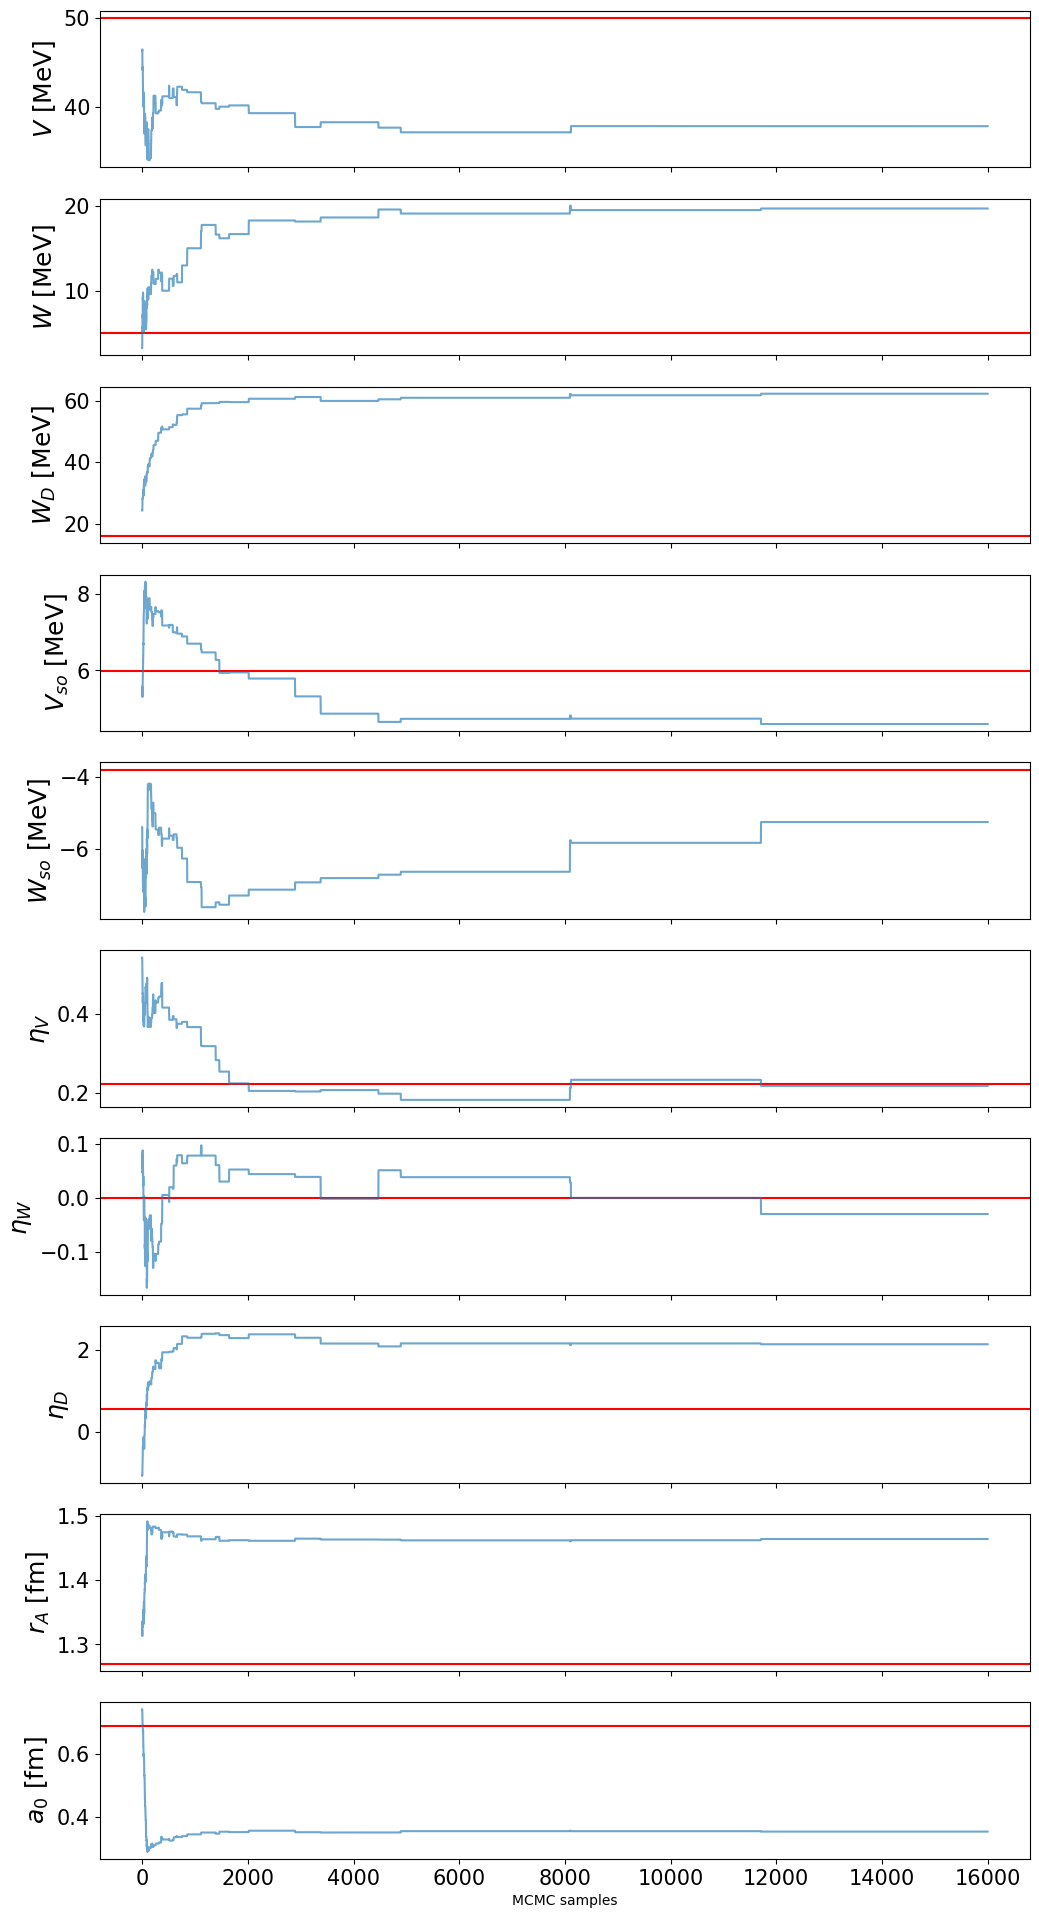

In [51]:
plt.rc("xtick", labelsize=15)
plt.rc("ytick", labelsize=15)
fig, axs = plt.subplots(elm_num_sub_params, 1, figsize=(12, 24), sharex="all")

for i in range(elm_num_sub_params):
    axs[i].axhline(y=mean[i], color="r")
    axs[i].set_ylabel(elm_param_labels[i], fontsize=18)
    for j in range(n_walkers):
        axs[i].plot(mcmc_samples[j,:,i], alpha=0.65)


plt.xlabel("MCMC samples")
plt.show()

In [52]:
acceptance_ratios = n_accepted / (n_iter - n_burn)
print(f'Acceptance ratios (should be around 1/3): {acceptance_ratios}')

Acceptance ratios (should be around 1/3): [0.0060625]


In [53]:
mcmc_samples.shape

(1, 16000, 10)

In [54]:
samples_per_walker = n_iter - n_burn
samples_per_walker

16000

In [55]:
posterior_samples = mcmc_samples.reshape((n_walkers*samples_per_walker,elm_num_sub_params))

## Plotting the results

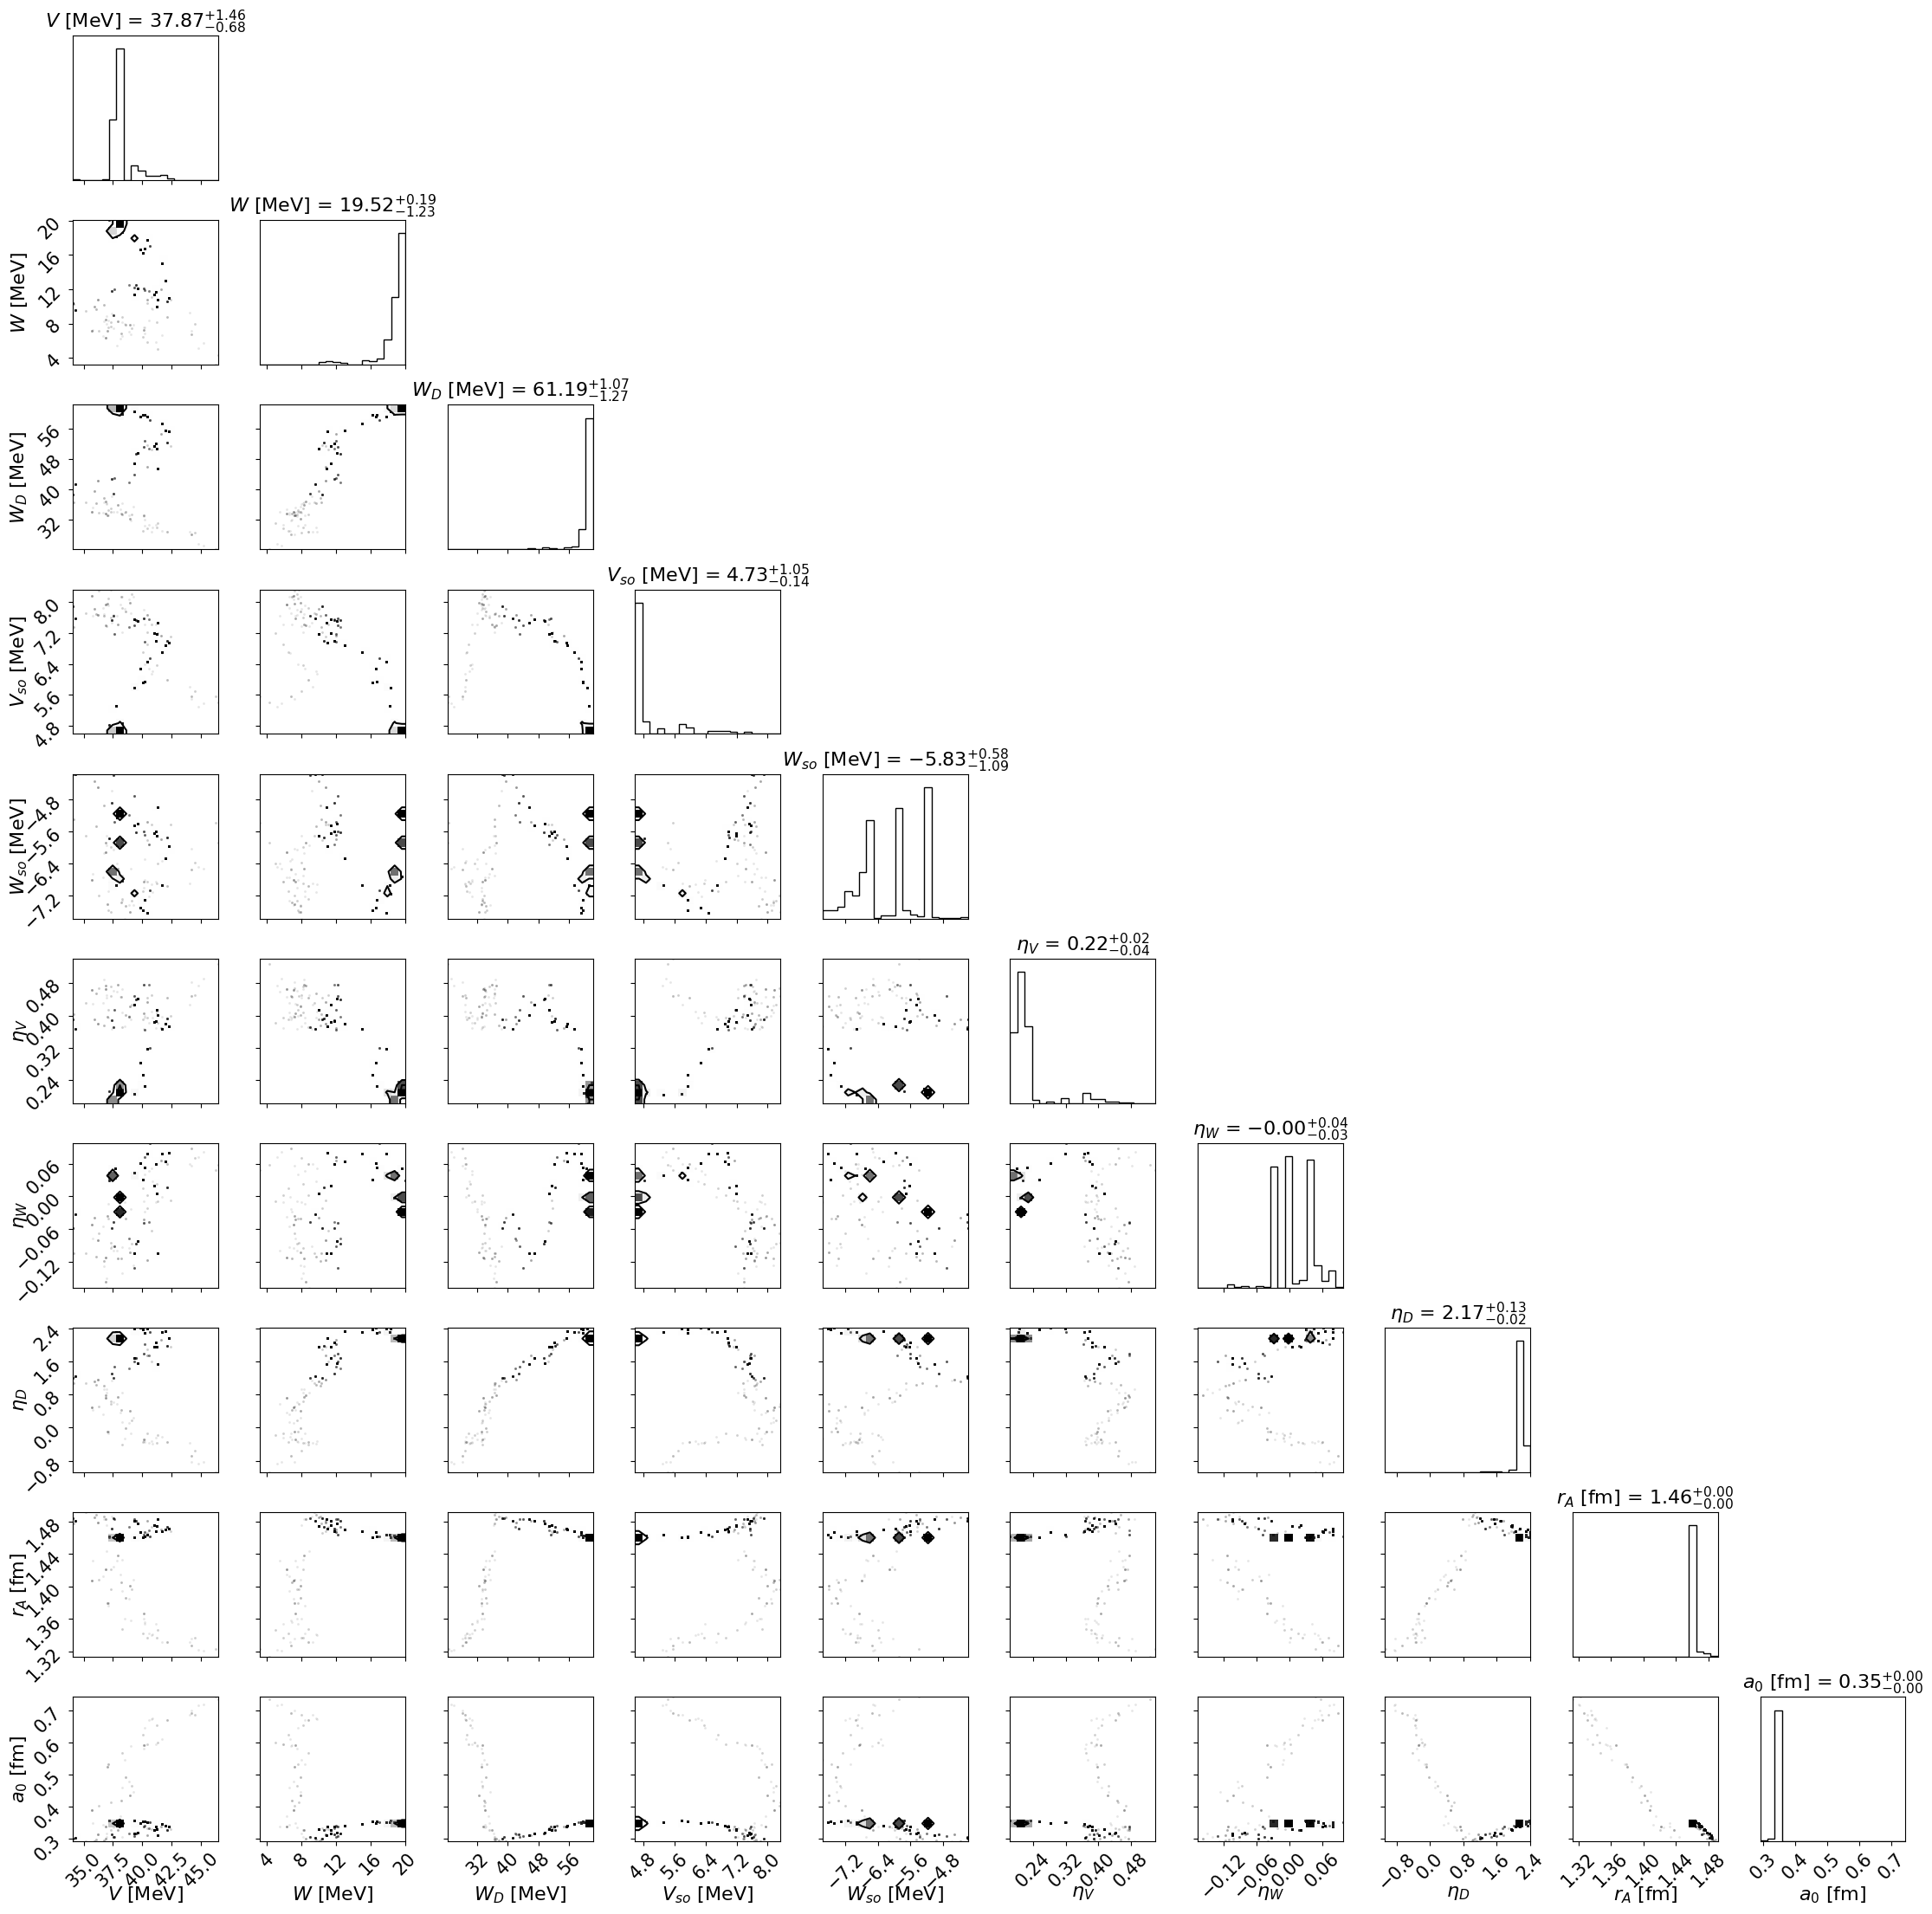

In [56]:
fig = corner.corner(
    posterior_samples,
    labels=list(elm_param_labels),
    show_titles=True,
    title_kwargs={"fontsize": 16},
    label_kwargs={"fontsize": 16},
)
fig.tight_layout()

  0%|          | 0/99 [00:00<?, ?it/s]

IndexError: index 15999 is out of bounds for axis 1 with size 100

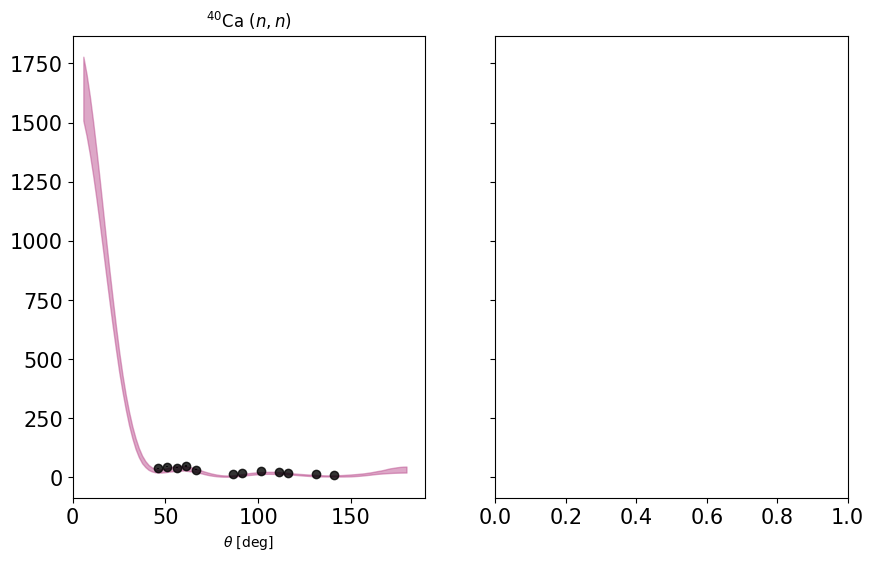

In [58]:
elm_xs = {}
elm_pred_post = {}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
for A, ax in zip(data.keys(), [ax1, ax2]):
    offset = 1
    ax.set_title(r"$^{%d}$Ca $(n,n)$" % A)
    ax.set_xlabel(r"$\theta$ [deg]")
    ax.set_xlim([0, 190])
    elm_xs[A] = {}
    elm_pred_post[A] = {}

    for experiment in data[A].keys():
        # plot experiment
        x, y, dy = (
            data[A][experiment][:, 0],
            data[A][experiment][:, 1],
            data[A][experiment][:, 2],
        )
        ax.errorbar(
            x,
            offset * y,
            offset * dy,
            marker="o",
            alpha=0.8,
            linestyle="none",
            color="k",
        )

        # plot KDUQ
        ax.fill_between(
            angles * 180 / np.pi,
            offset * kduq_pred_post[A][experiment][0],
            offset * kduq_pred_post[A][experiment][1],
            color="#bc5090",
            alpha=0.5,
        )

        # evaluate ELM
        elm_xs[A][experiment] = np.zeros((len(angles), N_samples))
        total_N = len(posterior_samples)
        for i in tqdm(range(total_N - 1, total_N - N_samples, -1)):
            params = el_model_params(*isotope, *posterior_samples[i, :])
            elm_xs[A][experiment][:, i] = (
                emulators[A][experiment].emulate_xs(params, angles=angles).dsdo
            )

        # get a credible interval describing the ELM predictive posterior
        # for this experiment
        elm_pred_post[A][experiment] = (
            np.percentile(elm_xs[A][experiment], 5, axis=1),
            np.percentile(elm_xs[A][experiment], 95, axis=1),
        )

        # plot ELM
        ax.fill_between(
            angles * 180 / np.pi,
            offset * elm_pred_post[A][experiment][0],
            offset * elm_pred_post[A][experiment][1],
            color="#FFCC80",
            alpha=0.5,
        )

        # add a label
        energy = energies[A][experiment]
        label_loc = (145, offset * np.min(y) / 2)
        ax.text(*label_loc, f"{energy} MeV")

        offset *= 20

leg_models = [
    Line2D(
        [0], [0], color="#bc5090", label=r"KDUQ $95\%$ credible interval", alpha=0.2
    ),
    Line2D([0], [0], color="#FFCC80", label=r"ELM $95\%$ credible interval", alpha=0.2),
]
leg1 = ax1.legend(handles=leg_models, loc="upper right")
ax1.add_artist(leg1)

plt.ylim([1, 1e6])
plt.yscale("log")
ax1.set_ylabel(r"$d\sigma/d\Omega$")
ax1.legend()

## Generate a predictive posterior for $^{60}$Ca and $^{70}$Ca!

In [59]:
# we'll probably never have experimental data for 70Ca(n,n) but let's pretend
Ca70 = (70,20)
Ca60 = (60,20)
energy = 10